## Predicting-Loan-repayment-for-banks

To predict the Loan repayment based on historical dataset from previous loan applications. Technologies: Machine learning Models using:

k-Nearest Neighbour
Decision Tree
Support Vector Machine
Logistic Regression

Results is reported as the accuracy of each classifier, using the following metrics:

Jaccard index
F1-score
LogLoass


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-02-08 03:28:27--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-02-08 03:28:27 (153 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [70]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y
print('seaborn package installed Successfully')

seaborn package installed Successfully


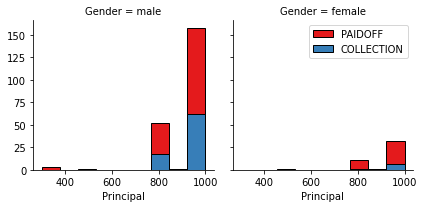

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

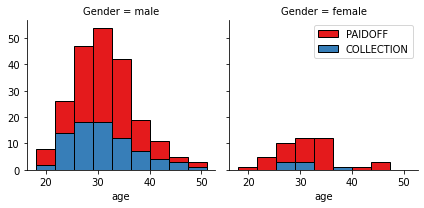

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


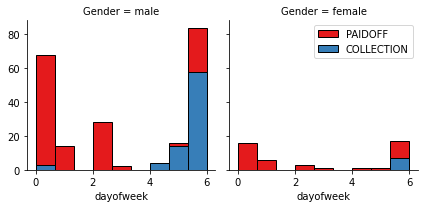

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


In [12]:
df['Month']=df.due_date.dt.month

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,10,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,10,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,9,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,10,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,10,1


## Convert Categorical features to numerical values


Lets look at gender:


In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1


In [17]:
df['deadline']=df['due_date']-df['effective_date']

In [18]:
df['deadline']=df['deadline'].dt.days
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1,29
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1,29


## One Hot Encoding

#### How about education?


In [19]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [20]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [21]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [22]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [23]:
y = df['loan_status'].values
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'],value=[0,1]).values
y[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [24]:
X= preprocessing.StandardScaler().fit_transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import jaccard_score
#from sklearn.metrics import jaccard_similarity_score

In [28]:
X_train,y_train=X,y

X_train.shape,y_train.shape


((346, 8), (346,))

In [29]:
trainscores={}


# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression



# K Nearest Neighbor(KNN)

Find the best k to build the model with the best accuracy.  


In [30]:
from sklearn.neighbors import KNeighborsClassifier
bestScore=0.0
accList=[]
for k in range(3,12):
    clf_knn=KNeighborsClassifier(n_neighbors=k,algorithm='auto')
    scores=cross_val_score(clf_knn,X,y,cv=10)
    score=scores.mean()
    accList.append(score)
    if score>bestScore:
        bestScore=score
        best_clf=clf_knn
        bestk=k
print('Best K value is',bestk,"Cross Validation Accuracy:",bestScore)
clf_knn=best_clf


Best K value is 7 Cross Validation Accuracy: 0.7438655462184873


In [31]:
clf_knn.fit(X_train,y_train)
y_pred=best_clf.predict(X_train)


In [74]:
trainscores['KNN-Jaccord']=jaccard_score(y_train,y_pred)

trainscores['KNN F1-Score']=f1_score(y_train,y_pred,average='weighted')
trainscores

{'KNN-Jaccord': 0.37142857142857144,
 'KNN F1-Score': 0.7955764876306204,
 'Tree-Jaccord': 0.6021505376344086,
 'Tree F1-Score': 0.8870748695908691,
 'SVM-Jaccord': 0.01098901098901099,
 'SVM F1-Score': 0.6441316913797436,
 'Logloss-Jaccord': 0.1326530612244898,
 'Logloss F1-Score': 0.6997291283105058}

<function matplotlib.pyplot.show(*args, **kw)>

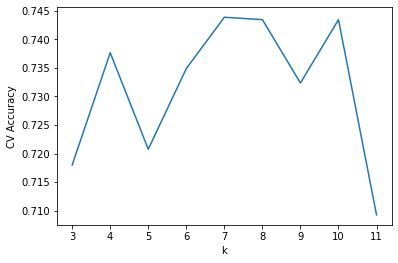

In [33]:
plt.plot(range(3,12),accList)
plt.xlabel('k')
plt.ylabel('CV Accuracy')
plt.show


# Decision Tree


In [41]:
from sklearn import tree
clf_tree=tree.DecisionTreeClassifier()
clf_tree=clf_tree.fit(X_train,y_train)
y_pred=clf_tree.predict(X_train)


In [42]:
trainscores['Tree-Jaccord']=jaccard_score(y_train,y_pred)
trainscores['Tree F1-Score']=f1_score(y_train,y_pred,average='weighted')
trainscores


{'KNN-Jaccord': 0.37142857142857144,
 'KNN F1-Score': 0.7955764876306204,
 'Tree-Jaccord': 0.6021505376344086,
 'Tree F1-Score': 0.8870748695908691,
 'SVM-Jaccord': 0.01098901098901099,
 'SVM F1-Score': 0.6441316913797436}

# Support Vector Machine


In [44]:
y_train=y_train.astype(float)


In [48]:
from sklearn import svm
clf_svm=svm.LinearSVC(random_state=3)
clf_svm.fit(X_train,y_train)
y_pred=clf_svm.predict(X_train)


In [49]:
trainscores['SVM-Jaccord']=jaccard_score(y_train,y_pred)
trainscores['SVM F1-Score']=f1_score(y_train,y_pred,average='weighted')
trainscores

{'KNN-Jaccord': 0.37142857142857144,
 'KNN F1-Score': 0.7955764876306204,
 'Tree-Jaccord': 0.6021505376344086,
 'Tree F1-Score': 0.8870748695908691,
 'SVM-Jaccord': 0.01098901098901099,
 'SVM F1-Score': 0.6441316913797436}

# Logistic Regression


In [55]:
from sklearn.linear_model import LogisticRegression
clf_log=LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial')
clf_log.fit(X_train,y_train)
y_pred=clf_log.predict(X_train)
y_proba=clf_log.predict_proba(X_train)

In [56]:
trainscores['Logloss-Jaccord']=jaccard_score(y_train,y_pred)
trainscores['Logloss F1-Score']=f1_score(y_train,y_pred,average='weighted')

trainscores

{'KNN-Jaccord': 0.37142857142857144,
 'KNN F1-Score': 0.7955764876306204,
 'Tree-Jaccord': 0.6021505376344086,
 'Tree F1-Score': 0.8870748695908691,
 'SVM-Jaccord': 0.01098901098901099,
 'SVM F1-Score': 0.6441316913797436,
 'Logloss-Jaccord': 0.1326530612244898,
 'Logloss F1-Score': 0.6997291283105058}

# Model Evaluation using Test set


In [57]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [58]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-02-08 04:16:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-02-08 04:16:28 (53.2 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [59]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [63]:
trainscores1={}

In [73]:
clf_knn.fit(X_train,y_train)
y_pred=best_clf.predict(X_train)

trainscores1['KNN-Jaccord']=jaccard_score(y_train,y_pred)
trainscores1['KNN F1-Score']=f1_score(y_train,y_pred,average='weighted')
trainscores1

{'KNN-Jaccord': 0.37142857142857144,
 'KNN F1-Score': 0.7955764876306204,
 'Tree-Jaccord': 0.6021505376344086,
 'Tree F1-Score': 0.8870748695908691,
 'SVM-Jaccord': 0.01098901098901099,
 'SVM F1-Score': 0.6441316913797436,
 'Logloss-Jaccord': 0.1326530612244898,
 'Logloss F1-Score': 0.6997291283105058,
 'LogReg Logloss': 0.43320342487163493}

In [65]:
from sklearn import tree
clf_tree=tree.DecisionTreeClassifier()
clf_tree=clf_tree.fit(X_train,y_train)
y_pred=clf_tree.predict(X_train)

trainscores1['Tree-Jaccord']=jaccard_score(y_train,y_pred)
trainscores1['Tree F1-Score']=f1_score(y_train,y_pred,average='weighted')
trainscores1

{'KNN-Jaccord': 0.37142857142857144,
 'KNN F1-Score': 0.7955764876306204,
 'Tree-Jaccord': 0.6021505376344086,
 'Tree F1-Score': 0.8870748695908691}

In [66]:
from sklearn import svm
clf_svm=svm.LinearSVC(random_state=3)
clf_svm.fit(X_train,y_train)
y_pred=clf_svm.predict(X_train)

trainscores1['SVM-Jaccord']=jaccard_score(y_train,y_pred)
trainscores1['SVM F1-Score']=f1_score(y_train,y_pred,average='weighted')
trainscores1

{'KNN-Jaccord': 0.37142857142857144,
 'KNN F1-Score': 0.7955764876306204,
 'Tree-Jaccord': 0.6021505376344086,
 'Tree F1-Score': 0.8870748695908691,
 'SVM-Jaccord': 0.01098901098901099,
 'SVM F1-Score': 0.6441316913797436}

In [69]:
from sklearn.linear_model import LogisticRegression
clf_log=LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial')
clf_log.fit(X_train,y_train)
y_pred=clf_log.predict(X_train)
y_proba=clf_log.predict_proba(X_train)

trainscores1['Logloss-Jaccord']=jaccard_score(y_train,y_pred)
trainscores1['Logloss F1-Score']=f1_score(y_train,y_pred,average='weighted')
trainscores1['LogReg Logloss']=log_loss(y_train,y_proba)

trainscores1

{'KNN-Jaccord': 0.37142857142857144,
 'KNN F1-Score': 0.7955764876306204,
 'Tree-Jaccord': 0.6021505376344086,
 'Tree F1-Score': 0.8870748695908691,
 'SVM-Jaccord': 0.01098901098901099,
 'SVM F1-Score': 0.6441316913797436,
 'Logloss-Jaccord': 0.1326530612244898,
 'Logloss F1-Score': 0.6997291283105058,
 'LogReg Logloss': 0.43320342487163493}

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.371   | 0.795    | NA      |
| Decision Tree      | 0.602   | 0.887    | NA      |
| SVM                | 0.710   | 0.644    | NA      |
| LogisticRegression | 0.732   | 0.699    | 0.433   |
